In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import seaborn as sns
import torch as th
import matplotlib.pyplot as plt
from aimanager.utils.utils import make_dir, load_yaml
from aimanager.utils.array_to_df import using_multiindex, add_labels
from aimanager.utils.merge import merge_files_by_name

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

run = '16_target_updated2'

folder = f'../../data/manager_v3/{run}'

train_folder = os.path.join(folder, 'metrics')
merge_file = os.path.join(folder, 'metrics.parquet')
model_folder = os.path.join(folder, 'model')

plot_folder = f'plots/{run}'

make_dir(plot_folder)

/mnt/beegfs/home/brinkmann/repros/algorithmic-institutions/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if not os.path.isfile(merge_file):
    dfs = [pd.read_parquet(os.path.join(train_folder, file)) for file in os.listdir(train_folder)]
    df = pd.concat(dfs)
    df.to_parquet(merge_file)
else:
    df = pd.read_parquet(merge_file)

In [3]:
df = df.rename(columns={
    'replay_memory': 'replay memory',
    'target_update_freq': 'update period',
    'round_number': 'round number',
    'update_step': 'training step',
})

In [4]:
non_labels = ['round number', 'sampling', 'training step', 'metric', 'value', 'job_id', 'run']

labels = [c for c in df.columns if c not in non_labels]


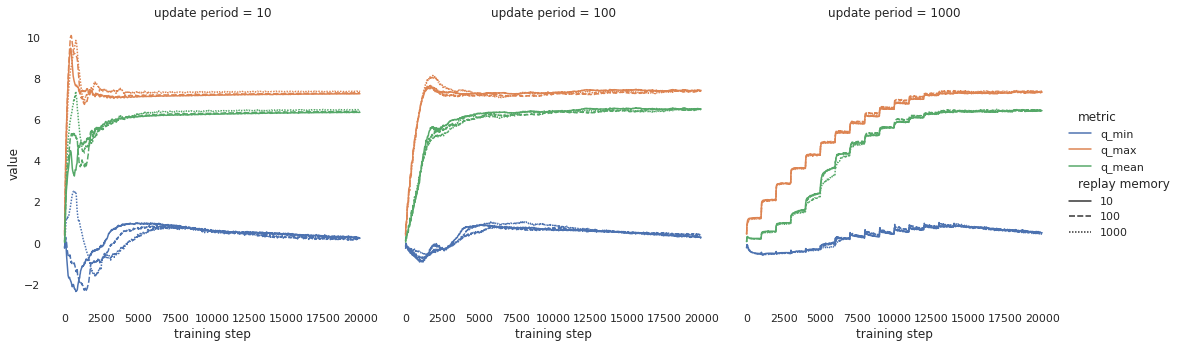

In [5]:
selection = {
    'eps': 0.2, 'gamma': 1, 'hidden_size': 20, 'lr': '3.e-4', 
    'memory_episodes': 100, 'sampling': 'greedy', 
    'target_update_freq': 200, 'features': 'contributions',
    'artificial_humans': 'complex'}

focus = ['training step', 'metric', 'replay memory', 'update period']

# selection = {k: v for k, v in ref.items() if k != focus}

w = pd.concat(
    (df[k] == v
    for k,v in selection.items() if (k not in focus) and (k in df.columns)
    ), axis=1
).all(1)
dfs = df[w].reset_index(drop=True).copy()

w = dfs['metric'].isin(['q_min', 'q_max', 'q_mean'])
dfs = dfs[w]


fg = sns.relplot(
    data=dfs, 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    style=focus[2] if len(focus) >= 3 else None,
    col=focus[3] if len(focus) >= 4 else None, 
    row=focus[4] if len(focus) >= 5 else None, 
    kind='line', ci=None)

fg.savefig(os.path.join(plot_folder, 'lc_q_values.jpg'))

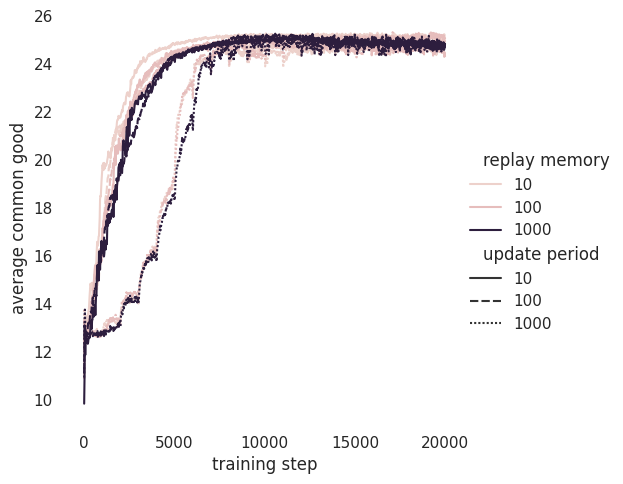

In [6]:
focus = ['training step', 'replay memory', 'update period']


w = pd.concat(
    (df[k] == v
    for k,v in selection.items() if (k not in focus) and (k in df.columns)
    ), axis=1
).all(1)
dfs = df[w].reset_index(drop=True).copy()

w = dfs['metric'].isin(['common_good'])
dfs = dfs[w]


fg = sns.relplot(
    data=dfs, 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    style=focus[2] if len(focus) >= 3 else None,
    col=focus[3] if len(focus) >= 4 else None, 
    row=focus[4] if len(focus) >= 5 else None, 
    kind='line', ci=None)

fg.set(ylabel='average common good')

fg.savefig(os.path.join(plot_folder, 'lc_common_good.jpg'))

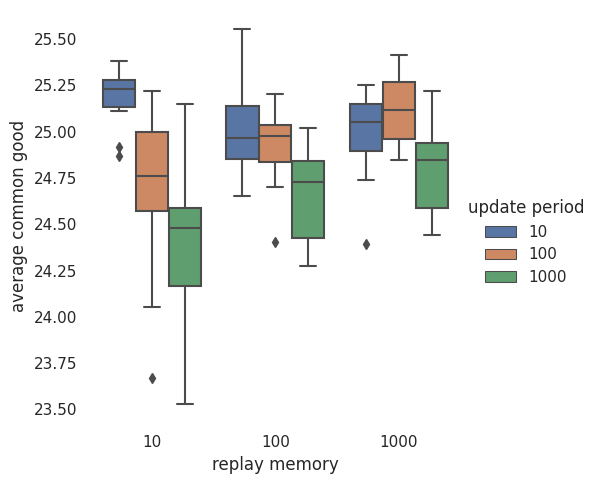

In [7]:
focus = ['replay memory', 'update period']


w = pd.concat(
    (df[k] == v
    for k,v in selection.items() if (k not in focus) and (k in df.columns)
    ), axis=1
).all(1)
dfs = df[w].reset_index(drop=True).copy()

w = dfs['metric'].isin(['common_good'])
dfs = dfs[w]

w_max = (dfs['training step'] > 8000) & (dfs['training step'] < 12000)
dfs = dfs[w_max].copy()

dfs = dfs.groupby(labels + ['run'])['value'].mean().reset_index()

fg = sns.catplot(
    data=dfs, 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    col=focus[2] if len(focus) >= 3 else None, 
    row=focus[3] if len(focus) >= 4 else None, 
    kind='box')


fg.set(ylabel='average common good')

fg.savefig(os.path.join(plot_folder, 'average_common_good.jpg'))